# Hand-crafted features for GTZAN

> The goal of this notebook is to create several audio features descriptors for the GTZAN dataset, as proposed for many year as input for machine learning algorithms. We are going to use timbral texture based features and tempo based features for this. The main goal is to produce this features, classify and then compare with our proposed deep learning approach, using CNNs on the raw audio.

In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
# Set the seed
np.random.seed(42)

In [4]:
gtzan_dir = '../data/genres/'

In [5]:
# Parameters
song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [6]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [7]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[x]
                arr_features.append(features)
    return arr_features

In [8]:
%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=False)

Wall time: 2min 21s


In [9]:
df_features = pd.DataFrame(features)

In [10]:
df_features.shape

(500, 134)

In [11]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,5514.393296,1789.366583,3176.995746,550.485825,1.277930,0.851571,9905.273438,4005.175781,6235.702536,1316.782580,...,-0.381803,-0.087361,20.820358,-32.647717,-4.103275,8.186303,0.171622,-0.170111,95.703125,0
1,5626.545444,1763.465470,2850.163030,450.508356,7.136744,1.872261,10314.404297,4155.908203,5926.993343,852.511470,...,-0.122148,0.049449,19.133055,-32.525146,-10.894270,7.584343,0.193536,0.236081,151.999081,0
2,4137.382271,1196.751465,2147.049597,394.428946,3.603367,1.476032,7751.953125,2842.382812,4376.752601,842.133273,...,-0.228953,-0.074895,11.926429,-40.928551,-14.248710,7.786307,0.161245,-0.130394,112.347147,0
3,4141.859853,1554.571724,2700.584556,411.301524,-0.256259,0.124371,7708.886719,3531.445312,5178.110839,679.032203,...,0.157389,-0.127252,16.922089,-34.641380,-13.005329,6.983782,0.370823,0.127291,99.384014,0
4,6472.152579,2069.514147,3357.385889,548.509155,1.316912,0.691435,10056.005859,4198.974609,6810.304320,964.532861,...,-0.134480,0.061888,23.652534,-27.224190,-3.429460,7.443413,0.033728,0.119981,135.999178,0


In [12]:
df_features.to_csv('../data/gtzan_features.csv', index=False)

In [13]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

## Visualization

> Linear (and nonlinear) dimensionality reduction of the GTZAN features for visualization purposes

In [14]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [15]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.8811


In [16]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

In [17]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.004s...
[t-SNE] Computed neighbors for 500 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.579725
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.489578
[t-SNE] KL divergence after 1000 iterations: 0.774880


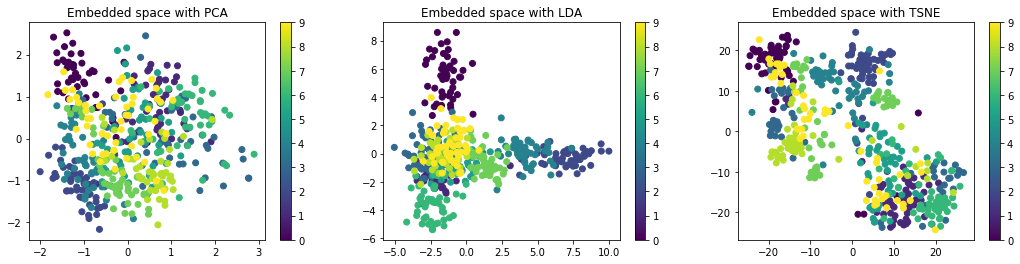

In [18]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

## Classical Machine Learning

In [19]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Logistic Regression

In [21]:
params = {
    "cls__penalty": ["l1", "l2"],
    "cls__C": [0.5, 1, 2, 5],
    "cls__max_iter": [500]
}

pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                            

In [22]:
preds = grid_lr.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7920
best score on test set (accuracy) = 0.7200


### ElasticNet

In [23]:
params = {
    "cls__loss": ['log'],
    "cls__penalty": ["elasticnet"],
    "cls__l1_ratio": [0.15, 0.25, 0.5, 0.75],
}

pipe_en = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SGDClassifier())
])

grid_en = GridSearchCV(pipe_en, params, scoring='accuracy', n_jobs=6, cv=5)
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                            

In [24]:
preds = grid_en.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_en.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7520
best score on test set (accuracy) = 0.6240


### Decision Tree

In [25]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                                                                 learning_rate=0.1,
                                                                                 max_depth=-1,
                                                                                 min_child_samples=20,
    

In [26]:
preds = grid_cart.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_cart.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.5600
best score on test set (accuracy) = 0.5120


### Random Forest

In [27]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                                                                 learning_rate=0.1,
                                                                                 max_depth=-1,
                                                                                 min_child_samples=20,
    

In [28]:
preds = grid_rf.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.7387
best score on test set (accuracy) = 0.7280


### SVM

In [29]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                            

In [30]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.8267
best score on test set (accuracy) = 0.7280


## Results and save the model

In [31]:
cm = confusion_matrix(y_test, preds)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

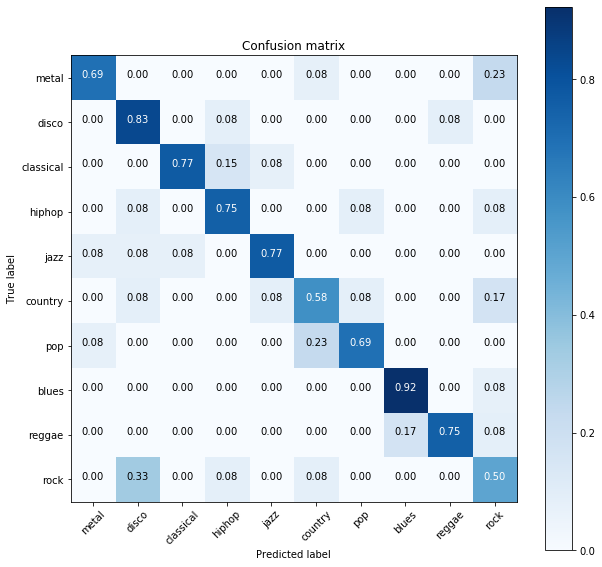

In [32]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [33]:
from sklearn.externals import joblib

c:\Users\wen\anaconda3\envs\MGC\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [34]:
joblib.dump(grid_svm, "../models/pipe_svm.joblib")

['../models/pipe_svm.joblib']